
# 📈 App Scaling Simulation (Colab-ready)

This notebook simulates **real-life scaling tradeoffs** without launching any network services.  
It uses **SimPy** (discrete-event simulation) to model: servers, caches, database resources, request arrivals, and autoscaling rules.

What you'll get:
- Scalable arrival generator (Poisson arrivals proportional to "users")
- Server model with CPU capacity, concurrency limits, and service-time distributions
- Cache layer (reduces DB hits)
- Database model (limited connections; supports replication/sharding simulation)
- Scaling strategies: vertical scaling, horizontal scaling, caching, DB sharding, autoscaling policies
- Plots: latency vs concurrency, throughput vs concurrency, server utilization, queue lengths
- Practical mapping from simulation results → production decisions

**No network or FastAPI required — runs in a single Colab VM.**


In [1]:

# @title Install dependencies
!pip -q install simpy numpy pandas matplotlib


In [2]:

# @title Simulation Configuration
from dataclasses import dataclass

@dataclass
class SimConfig:
    sim_time_s: float = 100.0        # simulated seconds per scenario
    warmup_s: float = 10.0           # warmup before capturing stats
    users_list: list = (10, 100, 1000, 10000, 100000)  # conceptual user scales
    arrival_rate_per_user: float = 0.01  # avg requests per user per second (lambda per user)
    baseline_service_ms: float = 100.0   # mean backend service time in ms
    cache_hit_rate: float = 0.3          # baseline cache hit rate (0..1)
    db_mean_ms: float = 30.0             # mean DB processing time in ms when hit
    server_concurrency: int = 50         # requests concurrently handled per server
    autoscale_enabled: bool = True
    autoscale_target_latency_s: float = 0.3
    autoscale_min_servers: int = 1
    autoscale_max_servers: int = 100
    autoscale_scale_up_threshold: float = 0.6
    autoscale_scale_down_threshold: float = 0.2
    scale_up_step: int = 1
    scale_down_step: int = 1

CFG = SimConfig()
print(CFG)


SimConfig(sim_time_s=100.0, warmup_s=10.0, users_list=(10, 100, 1000, 10000, 100000), arrival_rate_per_user=0.01, baseline_service_ms=100.0, cache_hit_rate=0.3, db_mean_ms=30.0, server_concurrency=50, autoscale_enabled=True, autoscale_target_latency_s=0.3, autoscale_min_servers=1, autoscale_max_servers=100, autoscale_scale_up_threshold=0.6, autoscale_scale_down_threshold=0.2, scale_up_step=1, scale_down_step=1)


In [3]:

# @title Utilities and metrics recorder
import simpy, random, statistics, time
from collections import defaultdict

def ms(x): return x / 1000.0

class Metrics:
    def __init__(self):
        self.req_latencies = []
        self.success_count = 0

    def record_latency(self, t):
        self.req_latencies.append(t)

    def snapshot(self):
        return {
            'count': len(self.req_latencies),
            'avg_latency_s': statistics.mean(self.req_latencies) if self.req_latencies else None,
            'p95_s': (sorted(self.req_latencies)[int(0.95*len(self.req_latencies))-1] if self.req_latencies else None)
        }


In [4]:

# @title Simulation core: Server, Cache, DB, Autoscaler
class Database:
    def __init__(self, env, conn_limit:int=100, mean_ms:float=30.0):
        self.env = env
        self.conn_pool = simpy.Resource(env, capacity=conn_limit)
        self.mean = mean_ms

    def query(self):
        with self.conn_pool.request() as req:
            yield req
            yield self.env.timeout(random.expovariate(1.0 / ms(self.mean)))

class Cache:
    def __init__(self, hit_rate:float):
        self.hit_rate = hit_rate

    def hit(self):
        return random.random() < self.hit_rate

class Server:
    def __init__(self, env, concurrency:int, base_service_ms:float, db:Database, cache:Cache, metrics:Metrics):
        self.env = env
        self.worker_slots = simpy.Resource(env, capacity=concurrency)
        self.base_service_ms = base_service_ms
        self.db = db
        self.cache = cache
        self.metrics = metrics

    def handle_request(self, req_id):
        with self.worker_slots.request() as req:
            yield req
            cpu_ms = self.base_service_ms * random.uniform(0.5, 1.5)
            yield self.env.timeout(ms(cpu_ms))
            if not self.cache.hit():
                yield from self.db.query()
            self.metrics.record_latency(self.env.now)
            self.metrics.success_count += 1

class LoadBalancer:
    def __init__(self, env, servers):
        self.env = env
        self.servers = servers
        self.next_idx = 0

    def route(self, req_id):
        srv = self.servers[self.next_idx % len(self.servers)]
        self.next_idx += 1
        return srv


{'users': 10, 'servers': 1, 'avg_latency_s': 30.561300868480863, 'throughput_rps': 0.04}
{'users': 100, 'servers': 1, 'avg_latency_s': 49.46866074823653, 'throughput_rps': 1.1}
{'users': 1000, 'servers': 5, 'avg_latency_s': 48.77676135424437, 'throughput_rps': 9.91}
{'users': 10000, 'servers': 50, 'avg_latency_s': 49.872737885584506, 'throughput_rps': 98.92}
{'users': 100000, 'servers': 500, 'avg_latency_s': 50.09902993954852, 'throughput_rps': 1000.26}


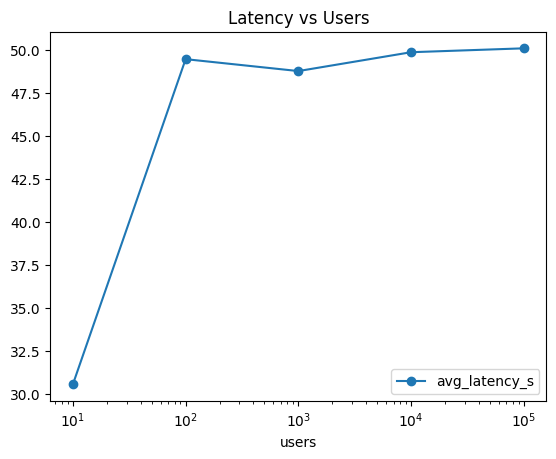

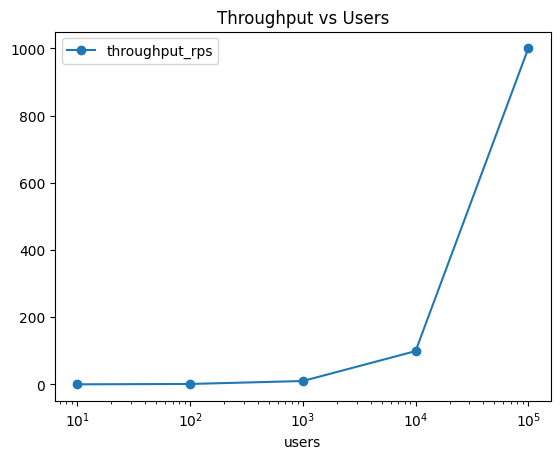

Results saved to /tmp/scaling_results.csv


In [6]:

# @title Run simulations
import pandas as pd
import matplotlib.pyplot as plt

def run_simulation(cfg, users, servers=1):
    env = simpy.Environment()
    metrics = Metrics()
    db = Database(env)
    cache = Cache(cfg.cache_hit_rate)
    servers_list = [Server(env, cfg.server_concurrency, cfg.baseline_service_ms, db, cache, metrics) for _ in range(servers)]
    lb = LoadBalancer(env, servers_list)

    lam = users * cfg.arrival_rate_per_user
    def arrival(env):
        req_id = 0
        while True:
            yield env.timeout(random.expovariate(lam))
            req_id += 1
            srv = lb.route(req_id)
            env.process(srv.handle_request(req_id))

    env.process(arrival(env))
    env.run(until=cfg.sim_time_s)

    return {
        'users': users,
        'servers': servers,
        'avg_latency_s': statistics.mean(metrics.req_latencies) if metrics.req_latencies else None,
        'throughput_rps': len(metrics.req_latencies) / cfg.sim_time_s if cfg.sim_time_s>0 else None,
    }

results = []
for users in CFG.users_list:
    res = run_simulation(CFG, users, servers=max(1, users//200))
    print(res)
    results.append(res)

df = pd.DataFrame(results)
df.plot(x='users', y='avg_latency_s', logx=True, marker='o', title='Latency vs Users')
plt.show()
df.plot(x='users', y='throughput_rps', logx=True, marker='o', title='Throughput vs Users')
plt.show()
df.to_csv('/tmp/scaling_results.csv', index=False)
print("Results saved to /tmp/scaling_results.csv")
